# Simulation of NMR CPMG experiments with ipywidgets

When **this notebook is opened**, then select in the menu, Kernel -> Restart & Run all.<br>
This is to refresh the widgets.

* [This noteboook is available at github.com/tlinnet/mybinder_relax](https://github.com/tlinnet/mybinder_relax/blob/master/CPMG_NMR_relax_interactive.ipynb)

* [The widgets can be seen at mybinder.org by clicking here](https://mybinder.org/v2/gh/tlinnet/mybinder_relax/master?filepath=CPMG_NMR_relax_interactive.ipynb)


# Jump to interactive plotting widgets

* [CR72 widget](#CR72_widget)
* ['NS CPMG 2-site expanded' widget](#NS_widget)
* [B14 widget](#B14_widget)
* [TSMFK01 widget](#TSMFK01_widget)
* [Examine Baldwin](#CR72_B14_widget)
* [Examine Rotten Banana](#banana)
* [References and links](#references)
* [Model differences](#modeldiff)

## Import code

In [1]:
### If relax is locally installed
import os, sys, pathlib
sys.path.append( os.path.join(str(pathlib.Path.home()), "software", "relax", "lib", "dispersion" ))
try:
    import cr72
# Else download it
except ImportError:
    import urllib.request
    urllib.request.urlretrieve('https://raw.githubusercontent.com/nmr-relax/relax/master/lib/dispersion/cr72.py', 'cr72.py')
    urllib.request.urlretrieve('https://raw.githubusercontent.com/nmr-relax/relax/master/lib/dispersion/ns_cpmg_2site_expanded.py', 'ns_cpmg_2site_expanded.py')
    urllib.request.urlretrieve('https://raw.githubusercontent.com/nmr-relax/relax/master/lib/dispersion/b14.py', 'b14.py')
    urllib.request.urlretrieve('https://raw.githubusercontent.com/nmr-relax/relax/master/lib/dispersion/tsmfk01.py', 'tsmfk01.py')
# import
import cr72
import ns_cpmg_2site_expanded
import b14
import tsmfk01

# See which file is used
print("Using file: %s"% cr72.__file__ )

Using file: /home/jovyan/software/relax/lib/dispersion/cr72.py


In [2]:
# Import python packages
import numpy as np
# Plotting. Set backend. This must be done before importing.
#%matplotlib inline
%matplotlib notebook
import matplotlib.pylab as plt
import matplotlib.colors as colors
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.mplot3d import Axes3D
#Remove figure max warning
plt.rcParams.update({'figure.max_open_warning': 0})

# Widgets
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# Image
from IPython.display import Image

# Pandas
import pandas as pd

## Calculate for models

Remade from http://dx.doi.org/10.1021/ja011300z

In [3]:
Image(url= "images/CPMG_pulse.png")

In [4]:
# Setup parameters
def cr72_calc(R20=None, dw_rad=None, pA=None, kex=None, cpmg_frqs=None):
    # For simpel model, R20A and R20B is the same
    R20A = R20B = R20
    # Make empty y_val
    y_R2 = np.zeros(cpmg_frqs.size)
    # Calculate y, and make in-memore replacement in y
    cr72.r2eff_CR72(r20a=R20A, r20a_orig=R20A, r20b=R20B, r20b_orig=R20B, 
           pA=pA, dw=dw_rad, dw_orig=dw_rad, kex=kex, 
           cpmg_frqs=cpmg_frqs, back_calc=y_R2)
    return y_R2

# Setup parameters
def ns_calc(R20=None, dw_rad=None, pA=None, kex=None, cpmg_frqs=None, relax_time=None, inv_relax_time=None, tcp=None, num_cpmg=None):
    # Make empty y_val
    y_R2 = np.zeros(cpmg_frqs.size)    
    # Calculate y, and make in-memore replacement in y
    ns_cpmg_2site_expanded.r2eff_ns_cpmg_2site_expanded(
            r20=R20, pA=pA, dw=dw_rad, dw_orig=dw_rad, kex=kex, 
            relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, 
            back_calc=y_R2, num_cpmg=num_cpmg)
    return y_R2

# Setup parameters
def b14_calc(R20=None, dw_rad=None, pA=None, kex=None, cpmg_frqs=None, relax_time=None, inv_relax_time=None, tcp=None, num_cpmg=None):
    # For simpel model, R20A and R20B is the same
    R20A = R20B = R20
    # Make empty y_val
    y_R2 = np.zeros(cpmg_frqs.size)    
    # Calculate y, and make in-memore replacement in y
    b14.r2eff_B14(r20a=R20A, r20b=R20B,
            pA=pA, dw=dw_rad, dw_orig=dw_rad, kex=kex,
            ncyc=num_cpmg, inv_tcpmg=inv_relax_time, tcp=tcp, back_calc=y_R2)
    return y_R2

def tsmfk01_calc(R20=None, dw_rad=None, kex=None, cpmg_frqs=None, tcp=None):
    # Rename parameters
    R20A = R20
    k_AB = kex
    # Make empty y_val
    y_R2 = np.zeros(cpmg_frqs.size)
    # Calculate y, and make in-memore replacement in y
    tsmfk01.r2eff_TSMFK01(r20a=R20A, dw=dw_rad, dw_orig=dw_rad, k_AB=k_AB, tcp=tcp, back_calc=y_R2)

    return y_R2

def calc_cpmg_frqs_tau(cpmg_e=None, relax_time=None):
    """
    @keyword cpmg_e:     The end value of the CPMG pulse train. In Hz.
    @keyword relax_time: The experiment specific fixed time period for relaxation (in seconds).
    """

    # First find the maximum number of recycling pulses
    Ncyc_max = cpmg_e * relax_time
    # Round up to nearest 1
    Ncyc_max = int(Ncyc_max + (- Ncyc_max % 1 ) )
    # Then make a range of Ncyc
    Ncyc_range = range(1, Ncyc_max+1)
    # Loop over Ncyc, and calculate
    tau_cpmg_arr = []
    cpmg_frqs_arr = []
    for Ncyc in Ncyc_range:
        # tcp. 2tcp is the time between the centers of successive 180 pulses in the CPMG sequence.
        tau_cpmg = relax_time / (4.*Ncyc)
        tau_cpmg_arr.append(tau_cpmg)
        # Calculate CPMG pulse train frequency v [Hz]
        cpmg_frq = 1. / (4.*tau_cpmg)
        cpmg_frqs_arr.append(cpmg_frq)
        # Calculate time between refocusing pulses
    # Convert to numpy
    num_cpmg = np.asarray(Ncyc_range)
    tcp = np.asarray(tau_cpmg_arr)
    x_cpmg_frqs = np.asarray(cpmg_frqs_arr)
    return x_cpmg_frqs, num_cpmg, tcp

# Calc for all models
def model_calc(model=None, cpmg_e=None, isotope=None, 
                relax_time=None, 
                w0_1H_s1=None, w0_1H_s2=None, 
                R20_s1=None, R20_s2=None, 
                dw_s1=None, dw_s2=None,
                pA_s1=None, pA_s2=None, 
                kex_s1=None, kex_s2=None):
    """
    @keyword model:      The model to analyse. 'CR72' or 'NS'.
    @keyword cpmg_e:     The end value of the CPMG pulse train. In Hz.
    @keyword isotope:    The isotope of nuclei. Either 1H, 15N or 13C.
    @keyword relax_time: The experiment specific fixed time period for relaxation (in seconds).
    @keyword w0_1H:      The spin Larmor frequencies for proton. In MHz.
    @keyword R20:        The transversal relaxation rate. In rad/s.
    @keyword dw:         The chemical shift difference between states A and B (in ppm).
    @keyword pA:         The population of state A.
    @keyword kex:        The exchange rate. In rad/s
    """
    # Gyromagnetic Ratio in [MHz/T]
    # http://bio.groups.et.byu.net/LarmourFreqCal.phtml
    g = {'1H':42.576, '15N':4.3156, '13C':10.705}
    # Magnet Field Strength [T]
    B0_s1 = w0_1H_s1 / g['1H']
    B0_s2 = w0_1H_s2 / g['1H']
    # Larmor frequency for isotope [MHz]
    w0_isotope_s1 = g[isotope]*B0_s1
    w0_isotope_s2 = g[isotope]*B0_s2
    # Convert dw in ppm to rad/s
    dw_rad_s1 = dw_s1 * w0_isotope_s1*2*np.pi
    dw_rad_s2 = dw_s2 * w0_isotope_s2*2*np.pi

    # Make x values. In Hz.
    inv_relax_time = 1.0 / relax_time
    #x_cpmg_frqs, num_cpmg, tcp = calc_cpmg_frqs_linspace_cpmg(cpmg_e=cpmg_e, relax_time=relax_time)
    x_cpmg_frqs, num_cpmg, tcp = calc_cpmg_frqs_tau(cpmg_e=cpmg_e, relax_time=relax_time)
    
    if model=='CR72':
        y_R2_s1 = cr72_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs)
        y_R2_s2 = cr72_calc(R20=R20_s2, dw_rad=dw_rad_s2, pA=pA_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs)
    elif model=='NS':
        y_R2_s1 = ns_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
        y_R2_s2 = ns_calc(R20=R20_s2, dw_rad=dw_rad_s2, pA=pA_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
    elif model=='B14':
        y_R2_s1 = b14_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
        y_R2_s2 = b14_calc(R20=R20_s2, dw_rad=dw_rad_s2, pA=pA_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
    elif model=='TSMFK01':
        y_R2_s1 = tsmfk01_calc(R20=R20_s1, dw_rad=dw_rad_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs, tcp=tcp)
        y_R2_s2 = tsmfk01_calc(R20=R20_s2, dw_rad=dw_rad_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, tcp=tcp)
    elif model=='CR72_NS':
        y_R2_s1 = cr72_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs)
        y_R2_s2 = ns_calc(R20=R20_s2, dw_rad=dw_rad_s2, pA=pA_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
    elif model=='CR72_B14':
        y_R2_s1 = cr72_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs)
        y_R2_s2 = b14_calc(R20=R20_s2, dw_rad=dw_rad_s2, pA=pA_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
    elif model=='NS_B14':
        y_R2_s1 = ns_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
        y_R2_s2 = b14_calc(R20=R20_s2, dw_rad=dw_rad_s2, pA=pA_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
    elif model=='CR72_TSMFK01':
        y_R2_s1 = cr72_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs)
        y_R2_s2 = tsmfk01_calc(R20=R20_s2, dw_rad=dw_rad_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, tcp=tcp)
    elif model=='NS_TSMFK01':
        y_R2_s1 = ns_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
        y_R2_s2 = tsmfk01_calc(R20=R20_s2, dw_rad=dw_rad_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, tcp=tcp)
    elif model=='B14_TSMFK01':
        y_R2_s1 = b14_calc(R20=R20_s1, dw_rad=dw_rad_s1, pA=pA_s1, kex=kex_s1, cpmg_frqs=x_cpmg_frqs, relax_time=relax_time, inv_relax_time=inv_relax_time, tcp=tcp, num_cpmg=num_cpmg)
        y_R2_s2 = tsmfk01_calc(R20=R20_s2, dw_rad=dw_rad_s2, kex=kex_s2, cpmg_frqs=x_cpmg_frqs, tcp=tcp)
        
    return x_cpmg_frqs, y_R2_s1, y_R2_s2, w0_isotope_s1, w0_isotope_s2

# Make a plot
def plot_calc(ax=None, model='CR72', cpmg_e=1000, isotope='15N', 
                relax_time = 0.06, 
                w0_1H_s1=750., w0_1H_s2=750., 
                R20_s1=13.9, R20_s2=13.9, 
                dw_s1=1.02, dw_s2=0.69,
                pA_s1=0.87, pA_s2=0.5, 
                kex_s1=4027., kex_s2=4061., 
                R20_min=0.0):
    """
    @keyword ax:         The matplotlib axis to plot on.
    @keyword model:      The model to analyse. 'CR72' or 'NS'.
    @keyword cpmg_e:     The end value of the CPMG pulse train. In Hz.
    @keyword isotope:    The isotope of nuclei. Either 1H, 15N or 13C.
    @keyword relax_time: The experiment specific fixed time period for relaxation (in seconds).
    @keyword w0_1H:      The spin Larmor frequencies for proton. In MHz.
    @keyword R20:        The transversal relaxation rate. In rad/s.
    @keyword dw:         The chemical shift difference between states A and B (in ppm).
    @keyword pA:         The population of state A.
    @keyword kex:        The exchange rate. In rad/s
    @keyword R20_min:    The minimum range of graph.
    """

    # Get x and y values
    x_cpmg_frqs, y_R2_s1, y_R2_s2, w0_isotope_s1, w0_isotope_s2 = model_calc(
                                        model=model, cpmg_e=cpmg_e, isotope=isotope, 
                                        relax_time=relax_time, 
                                        w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2, 
                                        R20_s1=R20_s1, R20_s2=R20_s2, 
                                        dw_s1=dw_s1, dw_s2=dw_s2,
                                        pA_s1=pA_s1, pA_s2=pA_s2, 
                                        kex_s1=kex_s1, kex_s2=kex_s2)
    
    # Make labels
    label_s1 = "sfrq=%.1f MHz\nR$_{2}^{0}$=%.1f rad/s\n$\Delta \omega$=%.1f ppm\np$_A$=%.3f \nk$_{ex}$=%.1f rad/s"%(w0_1H_s1, R20_s1, dw_s1, pA_s1, kex_s1)
    label_s2 = "sfrq=%.1f MHz\nR$_{2}^{0}$=%.1f rad/s\n$\Delta \omega$=%.1f ppm\np$_A$=%.3f \nk$_{ex}$=%.1f rad/s"%(w0_1H_s2, R20_s2, dw_s2, pA_s2, kex_s2)
    
    # Plot
    # Update if already existing
    if ax.lines:
        # Update x-data.
        ax.lines[0].set_xdata(x_cpmg_frqs)
        ax.lines[1].set_xdata(x_cpmg_frqs)

        # Update y-data.
        ax.lines[0].set_ydata(y_R2_s1)
        ax.lines[1].set_ydata(y_R2_s2)

        # Update legend
        ax.legend((ax.lines[0], ax.lines[1]), (label_s1, label_s2), loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(r"Isotope: %s with Larmor frequencies: $\omega_1$=%.1f $\omega_2$=%.1f MHz" % 
                     (isotope, w0_isotope_s1, w0_isotope_s2))
        # Set axis limits
        p_ylim_up = np.max(np.concatenate((y_R2_s1, y_R2_s2)))
        # Round up to nearest 5
        # Round up to nearest 5
        if model == 'TSMFK01':
            p_ylim_up = p_ylim_up + (- p_ylim_up % 2 )
        else:
            p_ylim_up = p_ylim_up + (- p_ylim_up % 5 )
        ax.set_ylim(R20_min, p_ylim_up)
    # Create new plot, if not existing
    else:
        # Plot
        ax.plot(x_cpmg_frqs, y_R2_s1, '.-', label=label_s1)
        ax.plot(x_cpmg_frqs, y_R2_s2, '.-', label=label_s2)
        # Set labels
        ax.set_xlabel("CPMG pulse train frequency v [Hz]")
        ax.set_ylabel("R$_{2}$,eff rad/s")
        ax.set_title(r"Isotope: %s with Larmor frequencies: $\omega_1$=%.1f $\omega_2$=%.1f MHz" % 
                     (isotope, w0_isotope_s1, w0_isotope_s2))

        # Set axis limits
        p_ylim_up = ax.get_ylim()[-1]
        # Round up to nearest 5
        if model == 'TSMFK01':
            p_ylim_up = p_ylim_up + (- p_ylim_up % 2 )
        else:
            p_ylim_up = p_ylim_up + (- p_ylim_up % 5 )
        ax.set_ylim(R20_min, p_ylim_up)
        # x_lim does not change
        ax.set_xlim(0, cpmg_e)

        # Put legend outside
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # Update canvas
    fig.canvas.draw()

## CR72 widget <a name="CR72_widget"></a>

When different parameters give same plot:

* http://dx.doi.org/10.1016/j.jmr.2006.01.010 or https://www.ncbi.nlm.nih.gov/pubmed/16458551

<IPython.core.display.Javascript object>


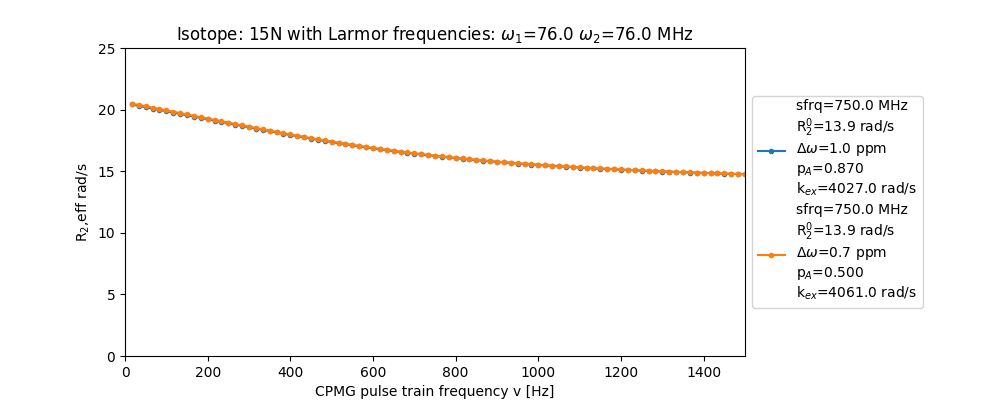

interactive(children=(FloatSlider(value=0.06, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=750.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=750.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=13.9, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=13.9, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=1.02, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=0.69, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.87, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.5, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=4027.0, description='kex_s1', max=10000.0, min=400.0, step=200.0), FloatSlider(value=4061.0, description='kex_s2', max=10000.0, min=400.0, step=200.0), FloatSlider(value=0.0, description='R20_min', step=5.0), Output()), _dom_classes=('widget-interact',))

In [5]:
# Make figure
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_cr72 = interactive(plot_calc, ax=fixed(ax),
                       model=fixed('CR72'), cpmg_e=fixed(1500), isotope=fixed('15N'), 
                       relax_time=(0.01, 0.1, 0.01), 
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.),
                       R20_min=(0.0, 100., 5.))
# Update fig
widget_cr72

## 'NS CPMG 2-site expanded' widget <a name="NS_widget"></a>

<IPython.core.display.Javascript object>


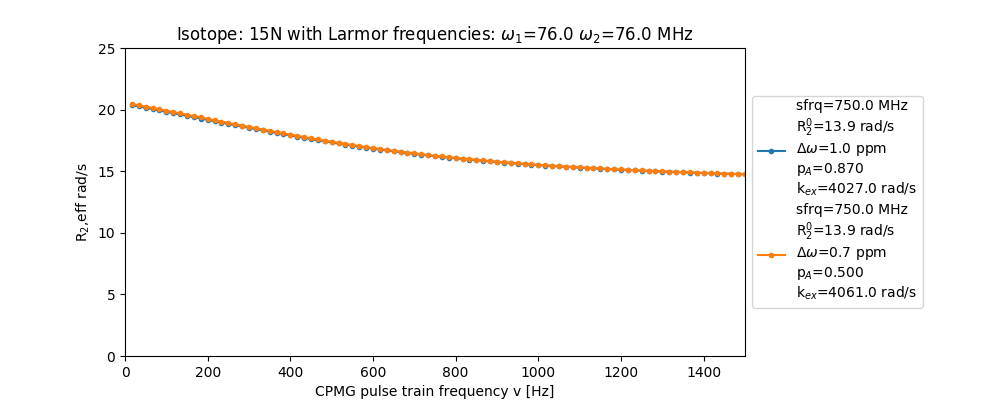

interactive(children=(FloatSlider(value=0.06, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=750.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=750.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=13.9, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=13.9, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=1.02, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=0.69, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.87, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.5, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=4027.0, description='kex_s1', max=10000.0, min=400.0, step=200.0), FloatSlider(value=4061.0, description='kex_s2', max=10000.0, min=400.0, step=200.0), FloatSlider(value=0.0, description='R20_min', step=5.0), Output()), _dom_classes=('widget-interact',))

In [6]:
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_ns = interactive(plot_calc, ax=fixed(ax),
                       model=fixed('NS'), cpmg_e=fixed(1500), isotope=fixed('15N'), 
                       relax_time=(0.01, 0.1, 0.01),
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.),
                       R20_min=(0.0, 100., 5.))

widget_ns

## B14 widget <a name="B14_widget"></a>

<IPython.core.display.Javascript object>


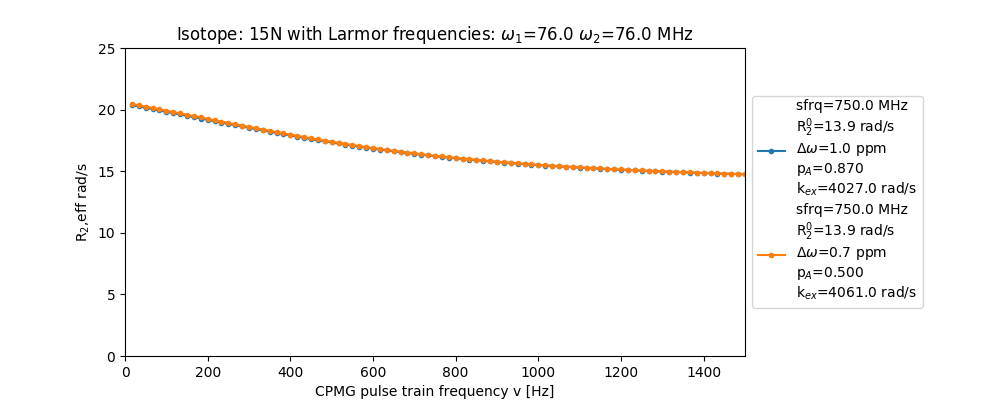

interactive(children=(FloatSlider(value=0.06, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=750.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=750.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=13.9, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=13.9, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=1.02, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=0.69, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.87, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.5, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=4027.0, description='kex_s1', max=10000.0, min=400.0, step=200.0), FloatSlider(value=4061.0, description='kex_s2', max=10000.0, min=400.0, step=200.0), FloatSlider(value=0.0, description='R20_min', step=5.0), Output()), _dom_classes=('widget-interact',))

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_b14 = interactive(plot_calc, ax=fixed(ax),
                       model=fixed('B14'), cpmg_e=fixed(1500), isotope=fixed('15N'), 
                       relax_time=(0.01, 0.1, 0.01),
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.),
                       R20_min=(0.0, 100., 5.))

widget_b14

## TSMFK01 widget <a name="TSMFK01_widget"></a>
Redo Figure 3 in http://dx.doi.org/10.1021/ja011300z

<IPython.core.display.Javascript object>


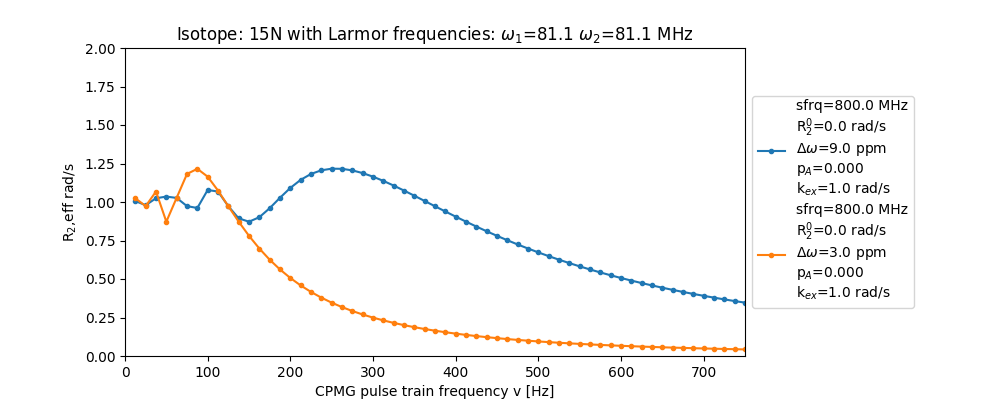

interactive(children=(FloatSlider(value=0.08, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=800.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=800.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=0.0, description='R20_s1', max=10.0, step=1.0), FloatSlider(value=0.0, description='R20_s2', max=10.0, step=1.0), FloatSlider(value=9.0, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=3.0, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=1.0, description='kex_s1', max=10.0, step=0.25), FloatSlider(value=1.0, description='kex_s2', max=10.0, step=0.25), FloatSlider(value=0.0, description='R20_min', max=10.0, step=1.0), Output()), _dom_classes=('widget-interact',))

In [8]:
# Make special plots
def plot_calc_tsmfk01(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=0.08,
                pA_s1=None, pA_s2=None, 
                w0_1H_s1=800., w0_1H_s2=800., 
                R20_s1=0., R20_s2=0., 
                dw_s1=9.0, dw_s2=3.0,
                kex_s1=1., kex_s2=1.,
                R20_min=0.0):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2,
             R20_min=R20_min)

fig, ax = plt.subplots(1, figsize=(10, 4))
widget_tsmfk01 = interactive(plot_calc_tsmfk01, ax=fixed(ax),
                       model=fixed('TSMFK01'), cpmg_e=fixed(750), isotope=fixed('15N'), 
                       relax_time=(0.01, 0.1, 0.01),
                       pA_s1=fixed(0), pA_s2=fixed(0),
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(0.0, 10.0, 1.), R20_s2=(0.0, 10.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       kex_s1=(0., 10, 0.25), kex_s2=(0., 10, 0.25),
                       R20_min=(0.0, 10., 1.))

widget_tsmfk01

Redo Figure 5 in http://dx.doi.org/10.1021/ja011300z

<IPython.core.display.Javascript object>


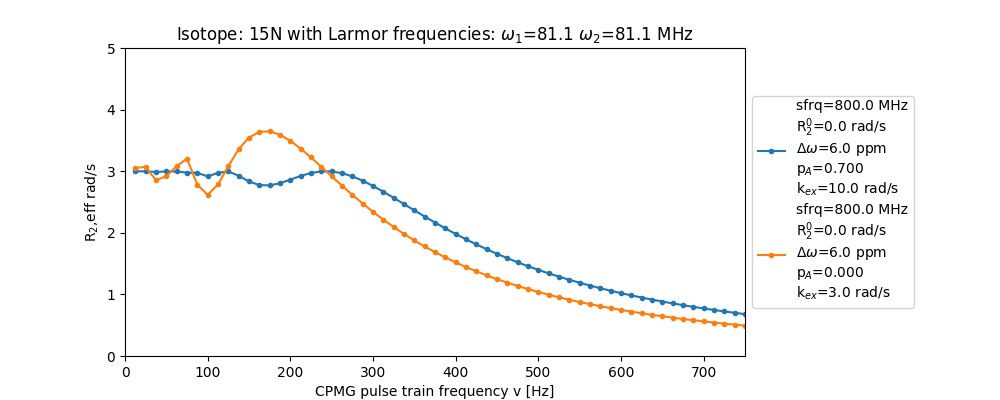

interactive(children=(FloatSlider(value=0.08, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=0.7, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=800.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=800.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=0.0, description='R20_s1', max=10.0, step=1.0), FloatSlider(value=0.0, description='R20_s2', max=10.0, step=1.0), FloatSlider(value=6.0, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=6.0, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=10.0, description='kex_s1', max=10.0, step=0.25), FloatSlider(value=3.0, description='kex_s2', max=10.0, step=0.25), FloatSlider(value=0.0, description='R20_min', max=10.0, step=1.0), Output()), _dom_classes=('widget-interact',))

In [9]:
# Get info from figure
#tex = 0.100 # 100 ms
#kex = 1./tex
#pB = 0.3
#pA = 1.0 - pB
#k_AB = pB * kex

# Make special plots
def plot_calc_tsmfk01_2(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=0.08,
                pA_s1=1.0-0.3, pA_s2=None, 
                w0_1H_s1=800., w0_1H_s2=800., 
                R20_s1=0., R20_s2=0., 
                dw_s1=6.0, dw_s2=6.0,
                kex_s1=1./0.1, kex_s2=0.3*(1./0.1),
                R20_min=0.0):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2,
             R20_min=R20_min)

fig, ax = plt.subplots(1, figsize=(10, 4))
widget_tsmfk01_2 = interactive(plot_calc_tsmfk01_2, ax=fixed(ax),
                       model=fixed('CR72_TSMFK01'), cpmg_e=fixed(750), isotope=fixed('15N'), 
                       relax_time=(0.01, 0.1, 0.01),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=fixed(0),
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(0.0, 10.0, 1.), R20_s2=(0.0, 10.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       kex_s1=(0., 10, 0.25), kex_s2=(0., 10, 0.25),
                       R20_min=(0.0, 10., 1.))

widget_tsmfk01_2

Compare to NS

<IPython.core.display.Javascript object>


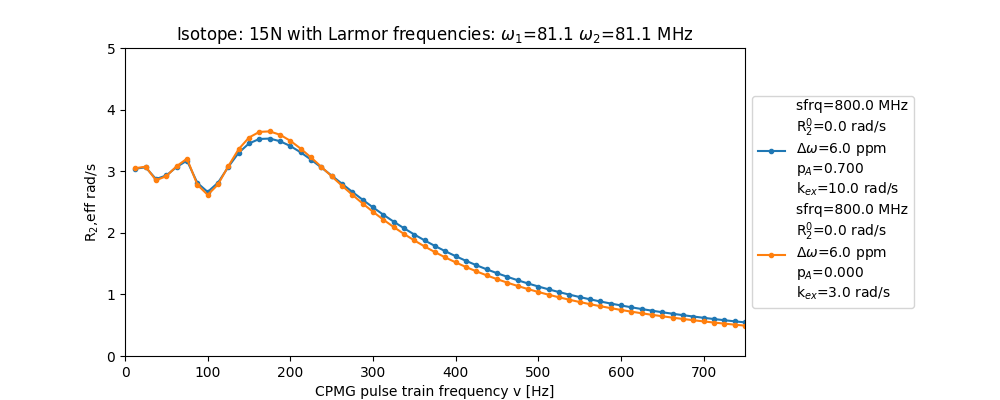

interactive(children=(FloatSlider(value=0.08, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=0.7, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=800.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=800.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=0.0, description='R20_s1', max=10.0, step=1.0), FloatSlider(value=0.0, description='R20_s2', max=10.0, step=1.0), FloatSlider(value=6.0, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=6.0, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=10.0, description='kex_s1', max=20.0, step=0.25), FloatSlider(value=3.0, description='kex_s2', max=20.0, step=0.25), FloatSlider(value=0.0, description='R20_min', max=10.0, step=1.0), Output()), _dom_classes=('widget-interact',))

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_tsmfk01_3 = interactive(plot_calc_tsmfk01_2, ax=fixed(ax),
                       model=fixed('NS_TSMFK01'), cpmg_e=fixed(750), isotope=fixed('15N'),
                       relax_time=(0.01, 0.1, 0.01),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=fixed(0),
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(0.0, 10.0, 1.), R20_s2=(0.0, 10.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       kex_s1=(0., 20, 0.25), kex_s2=(0., 20, 0.25),
                       R20_min=(0.0, 10., 1.))

widget_tsmfk01_3

Compare to B14

<IPython.core.display.Javascript object>


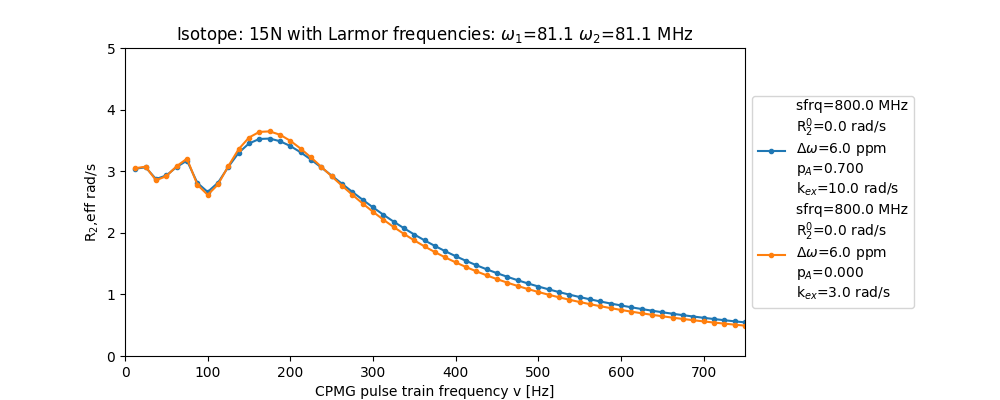

interactive(children=(FloatSlider(value=0.08, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=0.7, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=800.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=800.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=0.0, description='R20_s1', max=10.0, step=1.0), FloatSlider(value=0.0, description='R20_s2', max=10.0, step=1.0), FloatSlider(value=6.0, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=6.0, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=10.0, description='kex_s1', max=20.0, step=0.25), FloatSlider(value=3.0, description='kex_s2', max=20.0, step=0.25), FloatSlider(value=0.0, description='R20_min', max=10.0, step=1.0), Output()), _dom_classes=('widget-interact',))

In [11]:
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_tsmfk01_4 = interactive(plot_calc_tsmfk01_2, ax=fixed(ax),
                       model=fixed('B14_TSMFK01'), cpmg_e=fixed(750), isotope=fixed('15N'),
                       relax_time=(0.01, 0.1, 0.01),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=fixed(0),
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(0.0, 10.0, 1.), R20_s2=(0.0, 10.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       kex_s1=(0., 20, 0.25), kex_s2=(0., 20, 0.25),
                       R20_min=(0.0, 10., 1.))

widget_tsmfk01_4

## CR72 B14 & NS B15 widget <a name="CR72_B14_widget"></a>
Difference between the two models. See [A. Baldwin 2014, Fig. 1](http://dx.doi.org/10.1016/j.jmr.2014.02.023)

<IPython.core.display.Javascript object>


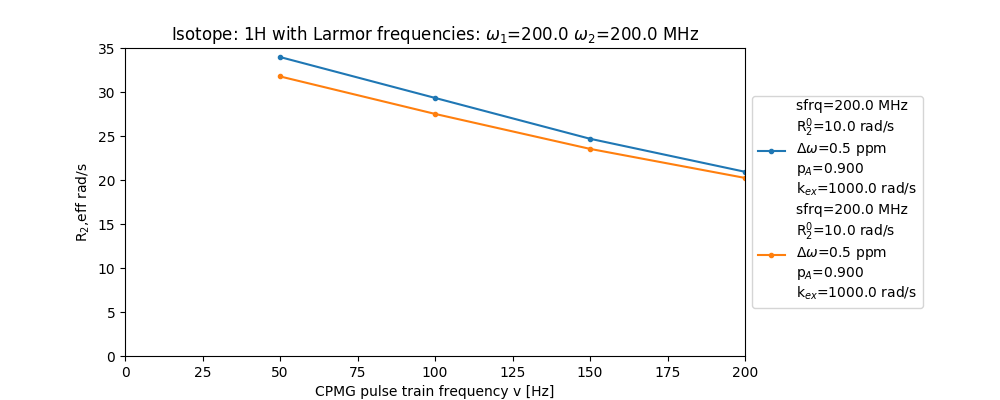

interactive(children=(FloatSlider(value=0.02, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=200.0, description='w0_1H_s1', max=1000.0, min=200.0, step=50.0), FloatSlider(value=200.0, description='w0_1H_s2', max=1000.0, min=200.0, step=50.0), FloatSlider(value=10.0, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=10.0, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=0.5, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=0.5, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.9, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.9, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=1000.0, description='kex_s1', max=10000.0, min=400.0, step=200.0), FloatSlider(value=1000.0, description='kex_s2', max=10000.0, min=400.0, step=200.0), FloatSlider(value=0.0, description='R20_min', max=50.0, step=1.0), Output()), _dom_classes=('widget-interact',))

In [12]:
def plot_calc_baldwin(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=0.02, 
                w0_1H_s1=200., w0_1H_s2=200., 
                R20_s1=10., R20_s2=10., 
                dw_s1=0.5, dw_s2=0.5,
                pA_s1=0.90, pA_s2=0.90, 
                kex_s1=1000., kex_s2=1000.,
                R20_min=0.0):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2,
             R20_min=R20_min)

# Make figure
fig, ax = plt.subplots(1, figsize=(10, 4))

# Make widget
widget_cr72_b14 = interactive(plot_calc_baldwin, ax=fixed(ax),
                       model=fixed('CR72_B14'), cpmg_e=fixed(200), isotope=fixed('1H'),
                       relax_time=(0.01, 0.1, 0.01),
                       w0_1H_s1=(200., 1000., 50), w0_1H_s2=(200., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.),
                       R20_min=(0.0, 50., 1.))

widget_cr72_b14

Recalculate for N15

In [13]:
def baldwin_to_N15():
    # Set sfrq
    g = {'1H':42.576, '15N':4.3156, '13C':10.705}
    w0_1H_1 = 200. # MHz
    B0_1 = w0_1H_1 / g['1H']
    w0_1H_2 = 800. # MHz
    B0_2 = w0_1H_2 / g['1H']
    print("B0_1: %.1f T, B0_2: %.1f T"%(B0_1, B0_2))
    print("w0_1H_1: %.1f MHz, w0_1H_2: %.1f MHz"%(w0_1H_1, w0_1H_2))
    # Calculate for isotope 15N
    isotope = '15N'
    w0_isotope_1 = g['15N']*B0_1
    w0_isotope_2 = g['15N']*B0_2
    print("w0_%s_1: %.1f MHz, w0_%s_2: %.1f MHz"%(isotope, w0_isotope_1, isotope, w0_isotope_2))
    # Set compare value
    R20_c = 10. # rad/s
    kex_c = 1000. # rad/s
    pA_c = 0.90
    print("\nR20_c: %.1f rad/s, kex_x: %.1f rad/s, pA_c: %.2f"%(R20_c, kex_c, pA_c))
    # dw in ppm
    dw_1H_1 = 0.5 # ppm
    print("\ndw_1H_1: %.2f ppm"%(dw_1H_1))
    # Calculate dw in rad/s for 1H
    dw_rad_1H_1 = dw_1H_1 * (w0_1H_1*2*np.pi)
    print("dw_rad_1H_1: %.1f rad/s"%(dw_rad_1H_1))
    # Calculate dw in ppm for 15N
    dw_isotope_1 = dw_rad_1H_1 / (w0_isotope_1*2*np.pi) # ppm
    print("dw_%s_1: %.2f ppm,"%(isotope, dw_isotope_1))
    # Calculate ppm for w0_1H_2
    dw_rad_1H_2 = dw_rad_1H_1
    dw_1H_2 = dw_rad_1H_2 / (w0_1H_2*2*np.pi)
    print("\ndw_1H_2: %.3f ppm"%(dw_1H_2))
    print("dw_rad_1H_2: %.1f rad/s"%(dw_rad_1H_2))
    # Calculate dw in ppm for 15N
    dw_isotope_2 = dw_rad_1H_2 / (w0_isotope_2*2*np.pi) # ppm
    print("dw_%s_2: %.3f ppm,"%(isotope, dw_isotope_2))
    
# Calc
baldwin_to_N15()

B0_1: 4.7 T, B0_2: 18.8 T
w0_1H_1: 200.0 MHz, w0_1H_2: 800.0 MHz
w0_15N_1: 20.3 MHz, w0_15N_2: 81.1 MHz

R20_c: 10.0 rad/s, kex_x: 1000.0 rad/s, pA_c: 0.90

dw_1H_1: 0.50 ppm
dw_rad_1H_1: 628.3 rad/s
dw_15N_1: 4.93 ppm,

dw_1H_2: 0.125 ppm
dw_rad_1H_2: 628.3 rad/s
dw_15N_2: 1.233 ppm,


For 15N at 200 MHz

<IPython.core.display.Javascript object>


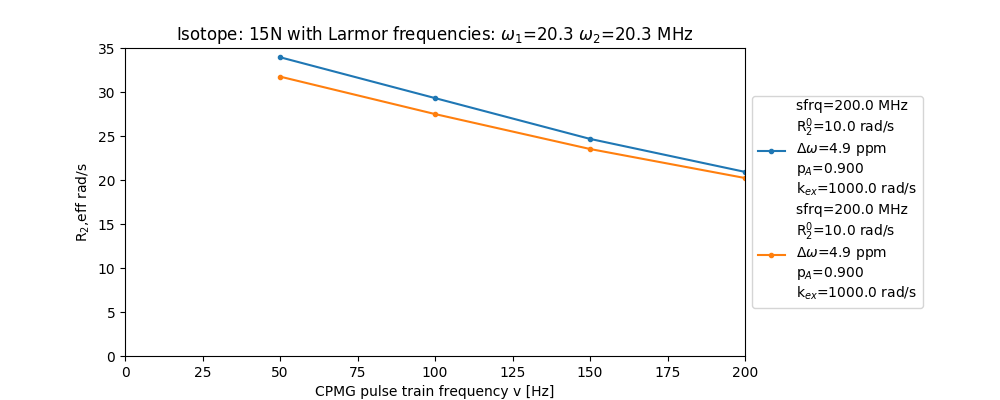

interactive(children=(FloatSlider(value=0.02, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=200.0, description='w0_1H_s1', max=1000.0, min=200.0, step=50.0), FloatSlider(value=200.0, description='w0_1H_s2', max=1000.0, min=200.0, step=50.0), FloatSlider(value=10.0, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=10.0, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=4.93, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=4.93, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.9, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.9, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=1000.0, description='kex_s1', max=10000.0, min=400.0, step=200.0), FloatSlider(value=1000.0, description='kex_s2', max=10000.0, min=400.0, step=200.0), FloatSlider(value=0.0, description='R20_min', step=1.0), Output()), _dom_classes=('widget-interact',))

In [14]:
def plot_calc_baldwin_N15(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=0.02, 
                w0_1H_s1=200., w0_1H_s2=200., 
                R20_s1=10., R20_s2=10., 
                dw_s1=4.93, dw_s2=4.93,
                pA_s1=0.90, pA_s2=0.90, 
                kex_s1=1000., kex_s2=1000.,
                R20_min=0.0):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2,
             R20_min=R20_min)

    # Make figure
fig, ax = plt.subplots(1, figsize=(10, 4))

# Make widget
widget_cr72_b14_N15 = interactive(plot_calc_baldwin_N15, ax=fixed(ax),
                       model=fixed('CR72_B14'), cpmg_e=fixed(200), isotope=fixed('15N'),
                       relax_time=(0.01, 0.1, 0.01),
                       w0_1H_s1=(200., 1000., 50), w0_1H_s2=(200., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.),
                       R20_min=(0.0, 100., 1.))

widget_cr72_b14_N15

For 15N at 800 MHz

<IPython.core.display.Javascript object>


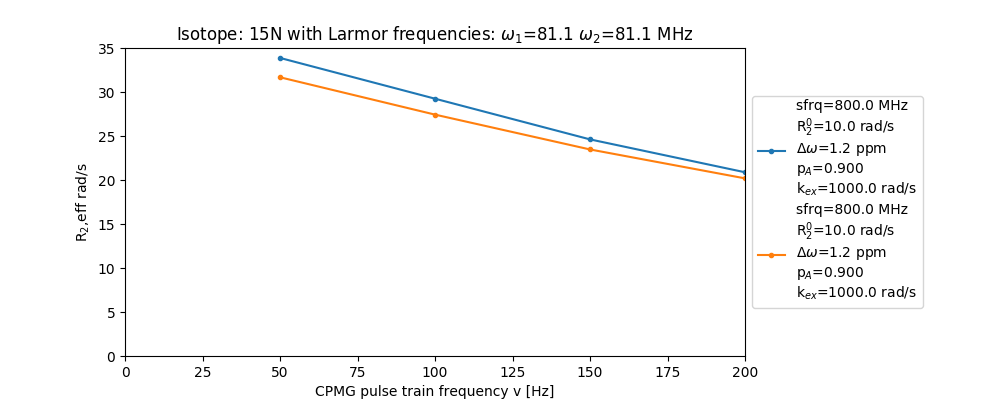

interactive(children=(FloatSlider(value=0.02, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=800.0, description='w0_1H_s1', max=1000.0, min=200.0, step=50.0), FloatSlider(value=800.0, description='w0_1H_s2', max=1000.0, min=200.0, step=50.0), FloatSlider(value=10.0, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=10.0, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=1.23, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=1.23, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.9, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.9, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=1000.0, description='kex_s1', max=10000.0, min=400.0, step=200.0), FloatSlider(value=1000.0, description='kex_s2', max=10000.0, min=400.0, step=200.0), FloatSlider(value=0.0, description='R20_min', step=1.0), Output()), _dom_classes=('widget-interact',))

In [15]:
def plot_calc_baldwin_N15_2(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=0.02, 
                w0_1H_s1=800., w0_1H_s2=800., 
                R20_s1=10., R20_s2=10., 
                dw_s1=1.23, dw_s2=1.23,
                pA_s1=0.90, pA_s2=0.90, 
                kex_s1=1000., kex_s2=1000.,
                R20_min=0.0):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2,
             R20_min=R20_min)

    # Make figure
fig, ax = plt.subplots(1, figsize=(10, 4))

# Make widget
widget_cr72_b14_N15 = interactive(plot_calc_baldwin_N15_2, ax=fixed(ax),
                       model=fixed('CR72_B14'), cpmg_e=fixed(200), isotope=fixed('15N'), 
                       relax_time=(0.01, 0.1, 0.01), 
                       w0_1H_s1=(200., 1000., 50), w0_1H_s2=(200., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.),
                       R20_min=(0.0, 100., 1.))

widget_cr72_b14_N15

Check that numerical solution NS is equal to Baldwin analytical

<IPython.core.display.Javascript object>


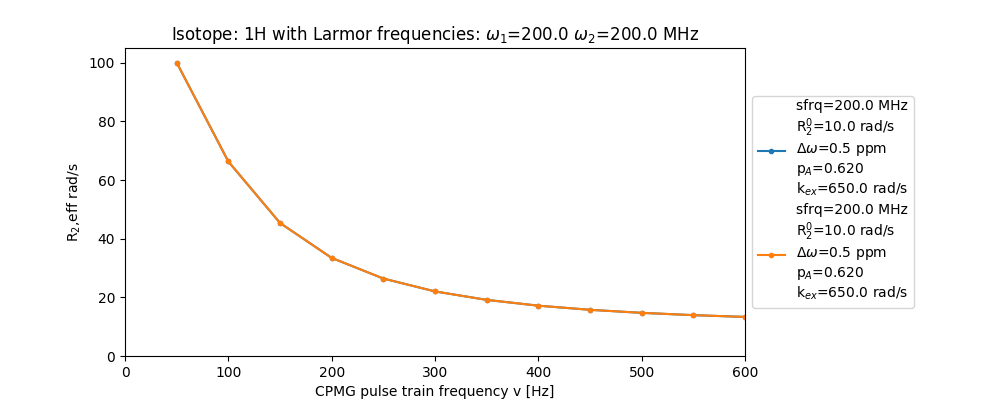

interactive(children=(FloatSlider(value=0.02, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=200.0, description='w0_1H_s1', max=1000.0, min=200.0, step=50.0), FloatSlider(value=200.0, description='w0_1H_s2', max=1000.0, min=200.0, step=50.0), FloatSlider(value=10.0, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=10.0, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=0.5, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=0.5, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.62, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.62, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=650.0, description='kex_s1', max=1000.0, min=400.0, step=50.0), FloatSlider(value=650.0, description='kex_s2', max=1000.0, min=400.0, step=50.0), Output()), _dom_classes=('widget-interact',))

In [16]:
def plot_calc_baldwin2(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=0.02, 
                w0_1H_s1=200., w0_1H_s2=200., 
                R20_s1=10., R20_s2=10., 
                dw_s1=0.5, dw_s2=0.5,
                pA_s1=0.62, pA_s2=0.62, 
                kex_s1=650., kex_s2=650.):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2)

fig, ax = plt.subplots(1, figsize=(10, 4))
widget_ns_b14 = interactive(plot_calc_baldwin2, ax=fixed(ax),
                       model=fixed('NS_B14'), cpmg_e=fixed(600), isotope=fixed('1H'),
                       relax_time=(0.01, 0.1, 0.01),
                       w0_1H_s1=(200., 1000., 50), w0_1H_s2=(200., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 1000, 50.), kex_s2=(400., 1000, 50.))

widget_ns_b14

Redo Fig. 1 in Baldwin.

In [17]:
# Isolate in function, to keep variables isolated
def baldwin(relax_time=0.02, 
            num=35, isotope = '1H', cpmg_e = 100.,
            w0_1H = 200., dw = 0.5, R20 = 10.):
    # Determine if to use logspace
    logspace = True
    # Range of values
    kex_min = 10
    kex_max = 5000
    pB_min = 0.1
    pB_max = 40
    if logspace:
        kex_range = np.logspace(np.log10(kex_min), np.log10(kex_max), num=num)
        pB_range = np.logspace(np.log10(pB_min), np.log10(pB_max), num=num)
    else:
        kex_range = np.linspace(kex_min, kex_max, num=num)
        pB_range = np.linspace(pB_min, pB_max, num=num)

    # Make meshgrid
    X,Y = np.meshgrid(kex_range, pB_range, indexing='xy')
    # Calculate Z
    Z_CR72 = np.zeros(X.shape)
    Z_B14 = np.zeros(X.shape)

    # Get shape of matrix
    # Loop over x. The columns
    for i in range(len(kex_range)):
        # Loop over y. The rows
        for j in range(len(pB_range)):
            # Get value, by row/column indexing
            kex=X[j][i]
            # Get population of excited state
            pB=Y[j][i]
            # Calculate for pA
            pA=1.0 - pB/100.
            x_cpmg_frqs, y_CR72, y_B14, w0_isotope_s1, w0_isotope_s2 = model_calc(
                                            model='CR72_B14', cpmg_e=cpmg_e, isotope=isotope, relax_time=relax_time, 
                                            w0_1H_s1=w0_1H, w0_1H_s2=w0_1H, R20_s1=R20, R20_s2=R20, 
                                            dw_s1=dw, dw_s2=dw, pA_s1=pA, pA_s2=pA, 
                                            kex_s1=kex, kex_s2=kex)
            # Fill value
            Z_CR72[j][i] = y_CR72[-1]
            Z_B14[j][i] = y_B14[-1]
            # Test
            #if y_B14[-1] > 65.0:
            #    print("kex=%.1f, pB=%.1f, pA=%.2f, R2eff=%.1f, i=%i, j=%i"% (kex, pB, pA, y_B14[-1], i, j))

    # Figure
    fig, axes = plt.subplots(2, 2, figsize=(5, 4))
    #fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    (ax1, ax2),(ax3, ax4) = axes

    # Plot for B14
    im1 = ax1.pcolormesh(kex_range, pB_range, Z_B14, cmap='autumn_r', vmin=0, vmax=70)
    # Plot for CR72
    im2 = ax2.pcolormesh(kex_range, pB_range, Z_CR72, cmap='autumn_r', vmin=0, vmax=70)
    # Plot for CR72 - B14
    Z3 = Z_CR72-Z_B14
    # Fill with nan to make white
    Z3[Z3 < 0.1] = np.nan

    im3 = ax3.pcolormesh(kex_range, pB_range, Z3, cmap='autumn_r', norm=colors.LogNorm(vmin=0.1, vmax=10) )
    # Plot for (CR72 - B14)/B14 * 100
    Z4 = (Z_CR72 - Z_B14)/Z_B14 * 100
    im4 = ax4.pcolormesh(kex_range, pB_range, Z4, cmap='autumn_r', vmin=0, vmax=14)

    # Set label
    ax1.set_title("B14")
    ax2.set_title("CR72")
    ax3.set_title("CR72-B14")
    ax4.set_title("(CR72 - B14)/B14 * 100")
    ax1.set_xlabel("k$_{ex}$ rad/s")
    ax2.set_xlabel("k$_{ex}$ rad/s")
    ax3.set_xlabel("k$_{ex}$ rad/s")
    ax4.set_xlabel("k$_{ex}$ rad/s")
    ax1.set_ylabel("P$_B$(%)")
    ax3.set_ylabel("P$_B$(%)")

    # If log scale
    if logspace:
        # Loop over axes
        for ax in axes.ravel():
            # x
            ax.set_xscale('log') 
            ax.xaxis.set_major_formatter(ScalarFormatter())
            # y
            ax.set_yscale('log') 
            ax.yaxis.set_major_formatter(ScalarFormatter())

    # Adjust layout
    plt.tight_layout()
    #plt.tight_layout(pad=2.0)
    
    # Add colorbar
    # First row
    plt.colorbar(im1, ax=[ax1])
    plt.colorbar(im2, ax=[ax2], label="R$_{2}$,eff rad/s")
    #plt.colorbar(im1, ax=[ax1, ax2], label="R$_{2}$,eff rad/s")
    # Second row
    #plt.colorbar(im3, ax=[ax3], label="R$_{2}$,eff rad/s")
    plt.colorbar(im3, ax=[ax3])
    plt.colorbar(im4, ax=[ax4], label="Relative difference (%)")

<IPython.core.display.Javascript object>


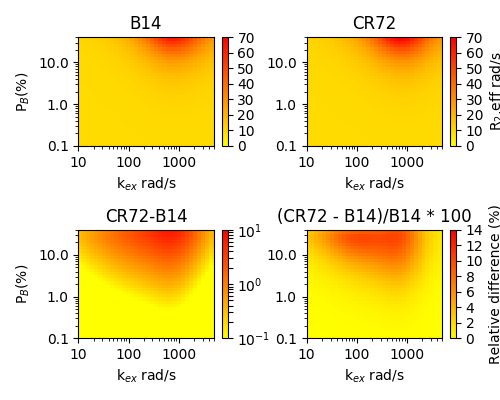

In [18]:
# Call function
baldwin(relax_time=0.02, num=35, isotope = '1H', cpmg_e = 100., w0_1H = 200., dw = 0.5)

<IPython.core.display.Javascript object>


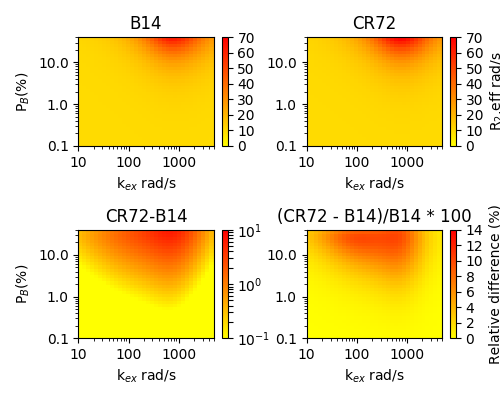

In [19]:
# For 800 MHz, 15N
baldwin(relax_time=0.02, num=35, isotope = '15N', cpmg_e = 100., w0_1H = 800., dw = 1.23)

<IPython.core.display.Javascript object>


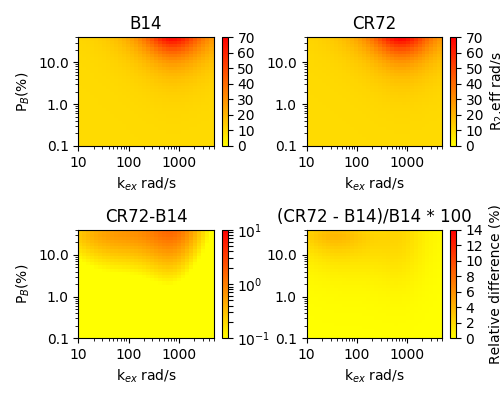

In [20]:
# For 800 MHz, 15N, longer relax_time
baldwin(relax_time=0.08, num=35, isotope = '15N', cpmg_e = 100., w0_1H = 800., dw = 1.23)

## Rotten banana widget <a name="banana"></a>
Examine minimization problems. See [Evgenii L. Kovrigin 1997, Fig. 2 and Fig. 5.](http://dx.doi.org/10.1016/j.jmr.2006.01.010)

First create reference figure. Calculate back from rad/s to ppm.

In [21]:
# Isolate in function, to keep variables isolated
def kovrigin_fig2_fig5():
    # From fig 2 + 5
    # Set sfrq
    g = {'1H':42.576, '15N':4.3156, '13C':10.705}
    w0_1H_1 = 800. # MHz
    B0_1 = w0_1H_1 / g['1H']
    w0_1H_2 = 500. # MHz
    B0_2 = w0_1H_2 / g['1H']
    print("B0_1: %.1f T, B0_2: %.1f T"%(B0_1, B0_2))
    print("w0_1H_1: %.1f MHz, w0_1H_2: %.1f MHz"%(w0_1H_1, w0_1H_2))
    # Calculate for isotope 15N
    isotope = '15N'
    w0_isotope_1 = g['15N']*B0_1
    w0_isotope_2 = g['15N']*B0_2
    print("w0_%s_1: %.1f MHz, w0_%s_2: %.1f MHz"%(isotope, w0_isotope_1, isotope, w0_isotope_2))
    # Set compare value
    R20_c = 15. # rad/s
    kex_c = 1000. # rad/s
    pA_c = 0.95
    print("\nR20_c: %.1f rad/s, kex_x: %.1f rad/s, pA_c: %.2f"%(R20_c, kex_c, pA_c))
    dw_rad_1H_1 = 1500 # rad/s
    dw_rad_1H_2 = w0_1H_2 / w0_1H_1 * dw_rad_1H_1 # Just scale accoring to sfrq
    print("\ndw_rad_1H_1: %.1f rad/s, dw_rad_1H_2: %.1f rad/s"%(dw_rad_1H_1, dw_rad_1H_2))
    # Calculate dw in ppm for 1H
    dw_1H_1 = dw_rad_1H_1 / (w0_1H_1*2*np.pi) # ppm
    dw_1H_2 = dw_rad_1H_2 / (w0_1H_2*2*np.pi) # ppm
    print("dw_1H_1: %.2f ppm, dw_1H_2: %.2f ppm"%(dw_1H_1, dw_1H_2))
    # Calculate dw in ppm for 15N
    dw_isotope_1 = dw_rad_1H_1 / (w0_isotope_1*2*np.pi) # ppm
    dw_isotope_2 = dw_rad_1H_2 / (w0_isotope_2*2*np.pi) # ppm
    print("dw_%s_1: %.2f ppm, dw_%s_2: %.2f ppm"%(isotope, dw_isotope_1, isotope, dw_isotope_2))
    
# Calc
kovrigin_fig2_fig5()

B0_1: 18.8 T, B0_2: 11.7 T
w0_1H_1: 800.0 MHz, w0_1H_2: 500.0 MHz
w0_15N_1: 81.1 MHz, w0_15N_2: 50.7 MHz

R20_c: 15.0 rad/s, kex_x: 1000.0 rad/s, pA_c: 0.95

dw_rad_1H_1: 1500.0 rad/s, dw_rad_1H_2: 937.5 rad/s
dw_1H_1: 0.30 ppm, dw_1H_2: 0.30 ppm
dw_15N_1: 2.94 ppm, dw_15N_2: 2.94 ppm


<IPython.core.display.Javascript object>


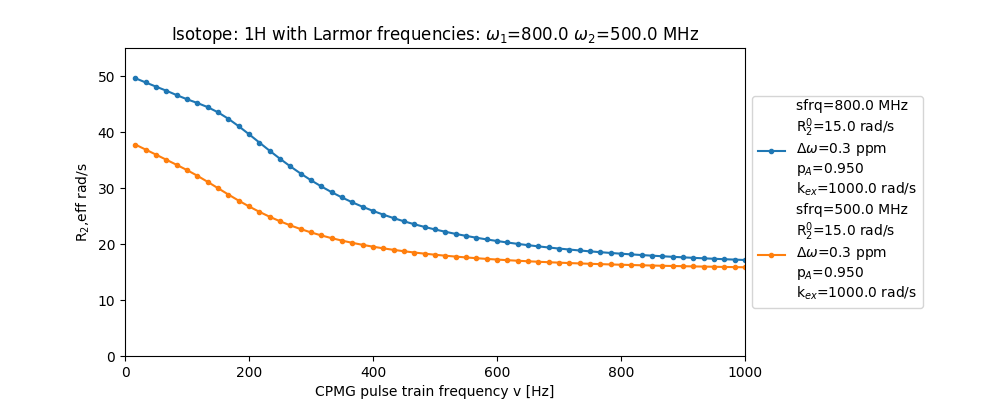

interactive(children=(FloatSlider(value=0.06, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=800.0, description='w0_1H_s1', max=1000.0, min=200.0, step=50.0), FloatSlider(value=500.0, description='w0_1H_s2', max=1000.0, min=200.0, step=50.0), FloatSlider(value=15.0, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=15.0, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=0.3, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=0.3, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.95, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.95, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=1000.0, description='kex_s1', max=5000.0, min=400.0, step=200.0), FloatSlider(value=1000.0, description='kex_s2', max=5000.0, min=400.0, step=200.0), Output()), _dom_classes=('widget-interact',))

In [22]:
def plot_calc_kovrigin(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=0.06, 
                w0_1H_s1=800.0, w0_1H_s2=500.0, 
                R20_s1=15., R20_s2=15., 
                dw_s1=0.3, dw_s2=0.3,
                pA_s1=0.95, pA_s2=0.95, 
                kex_s1=1000., kex_s2=1000.):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2)

# Make figure
fig, ax = plt.subplots(1, figsize=(10, 4))

# Make widget
widget_kovrigin = interactive(plot_calc_kovrigin, ax=fixed(ax),
                       model=fixed('B14'), cpmg_e=fixed(1000), isotope=fixed('1H'), 
                       relax_time=(0.01, 0.1, 0.01),
                       w0_1H_s1=(200., 1000., 50), w0_1H_s2=(200., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 5000, 200.), kex_s2=(400., 5000, 200.))

widget_kovrigin

Next create rotten banana

In [23]:
def sim_calc(chi2_max=None, num=None, Nfields=1,
                model=None, cpmg_e=None, isotope=None,
                relax_time = None, 
                w0_1H_s1=800.0, w0_1H_s2=500.0, 
                R20_s1=15.,
                dw_s1=0.3,
                pA_s1=0.95,
                kex_s1=1000.):
    """
    @keyword chi2_max:         The maximum for which to show values.
    @keyword num:        The number of grid points for each parameter.
    @keyword Nfields:    The number of spectrometer fields. Either 1 or 2.
    @keyword model:      The model to analyse. 'CR72' or 'NS'.
    @keyword cpmg_e:     The end value of the CPMG pulse train. In Hz.
    @keyword isotope:    The isotope of nuclei. Either 1H, 15N or 13C.
    @keyword relax_time: The experiment specific fixed time period for relaxation (in seconds).
    @keyword w0_1H:      The spin Larmor frequencies for proton. In MHz.
    @keyword R20:        The transversal relaxation rate. In rad/s.
    @keyword dw:         The chemical shift difference between states A and B (in ppm).
    @keyword pA:         The population of state A.
    @keyword kex:        The exchange rate. In rad/s
    """
    # Get x and y values, to compare against
    x_cpmg_frqs, y_R2_s1, y_R2_s2, w0_isotope_s1, w0_isotope_s2 = model_calc(
                                        model=model, cpmg_e=cpmg_e, isotope=isotope, 
                                        relax_time=relax_time, 
                                        w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2, 
                                        R20_s1=R20_s1, R20_s2=R20_s1, 
                                        dw_s1=dw_s1, dw_s2=dw_s1,
                                        pA_s1=pA_s1, pA_s2=pA_s1, 
                                        kex_s1=kex_s1, kex_s2=kex_s1)

    # Set dw range
    dw_rad_max = 2500 # rad/2
    # Calculate in ppm
    dw_max = round(dw_rad_max / (w0_isotope_s1*2*np.pi), 2) # ppm
    dw_min = dw_max / 10.
    print("isotope: %s, dw_min: %.2f, dw_max: %.2f " %(isotope, dw_min, dw_max))

    # Then make range of values to test
    kex_range = np.linspace(1., 3000, num=num)
    pA_range = np.linspace(0.5, 1.0, num=num)
    dw_range = np.linspace(dw_min, dw_max, num=num)

    # Loop over data
    xs = [] # kex
    ys = [] # pA
    zs = [] # dw
    cs = [] # Value of reduced chi2 as color
    # Find min, max
    for i, kex_c in enumerate(kex_range):
        for j, pA_c in enumerate(pA_range):
            for k, dw_c in enumerate(dw_range):
                # Get values
                _, y_R2_s1_c, y_R2_s2_c, _, _ = model_calc(
                                        model=model, cpmg_e=cpmg_e, isotope=isotope, 
                                        relax_time=relax_time, 
                                        w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2, 
                                        R20_s1=R20_s1, R20_s2=R20_s1, 
                                        dw_s1=dw_c, dw_s2=dw_c,
                                        pA_s1=pA_c, pA_s2=pA_c, 
                                        kex_s1=kex_c, kex_s2=kex_c)
                # If the number of fields is 2
                if Nfields == 2:
                    # Concatenate the y values
                    y_R2_c = np.concatenate((y_R2_s1_c, y_R2_s2_c))
                    y_R2 = np.concatenate((y_R2_s1, y_R2_s2))
                # Else expect 1 fields
                else:
                    # Use for field 1
                    y_R2_c = y_R2_s1_c
                    y_R2 = y_R2_s1
                # Then calculate chi2 
                # Chi2
                chi2 = np.sum((y_R2_c - y_R2)**2)
                # dof. degrees of freedom equals. The number of values minus the number of parameters
                n_par = 3
                n_obs = len(y_R2_c)
                dof = n_obs - n_par
                # Reduced chi2
                red_chi2 = chi2/dof
                # Avg chi2
                avg_chi2 = chi2/n_obs
                # Assign values
                xs.append(kex_c)
                ys.append(pA_c)        
                zs.append(dw_c)
                #cs.append(chi2)
                cs.append(red_chi2)
                #cs.append(avg_chi2)

    #  Convert to numpy array
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    zs = np.asarray(zs)
    cs = np.asarray(cs)

     # Make filter for removing data points, according to percentile of points
    #innermost = np.percentile(cs, percentile)
    # Make mask
    #Nan_f = cs > innermost
    Nan_f = cs > chi2_max
    # Copy and replace
    xs_sel = np.copy(xs)
    ys_sel = np.copy(ys)
    zs_sel = np.copy(zs)
    cs_sel = np.copy(cs)
    # Replace with nan according to mask. This removes data points in graph.
    xs_sel[Nan_f] = np.nan
    ys_sel[Nan_f] = np.nan
    zs_sel[Nan_f] = np.nan
    cs_sel[Nan_f] = np.nan
    
    return xs, xs_sel, ys, ys_sel, zs, zs_sel, cs, cs_sel

# Ref values for dw_rad_1H_1 = 1500 # rad/s at 800 MHz.
#dw_1H = 0.03 # ppm
#dw_15N = 2.39 #
def plot_sim(ax=None, chi2_max=5.,
                num=None, Nfields=1,
                model=None, cpmg_e=None, isotope='15N',
                relax_time = None, 
                w0_1H_s1=800.0, w0_1H_s2=500.0, 
                R20_s1=15., 
                dw_s1=2.39,
                pA_s1=0.95,
                kex_s1=1000.):
    """
    @keyword ax:               The matplotlib axis to plot on.
    @keyword chi2_max:         The maximum for which to show values.
    """

    # Get values
    xs, xs_sel, ys, ys_sel, zs, zs_sel, cs, cs_sel = sim_calc(
                chi2_max=chi2_max, num=num, Nfields=Nfields,
                model=model, cpmg_e=cpmg_e, isotope=isotope,
                relax_time=relax_time,
                w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2, 
                R20_s1=R20_s1,
                dw_s1=dw_s1,
                pA_s1=pA_s1,
                kex_s1=kex_s1)

    # Plot reference
    ax.scatter(kex_s1, pA_s1, dw_s1, c="r", marker="^", s=200)
    # Plot points and color bar
    p = ax.scatter(xs_sel, ys_sel, zs_sel, c=cs_sel, vmin=0.0, vmax=chi2_max)
    #plt.colorbar(p, label="The average $\chi^2_{avg}$")
    plt.colorbar(p, label="The reduced $\chi^2_{v}$")
    
    # Set labels and range
    # x
    ax.set_xlabel('k$_{ex}$ [rad/s]')
    ax.set_xlim(np.min(xs), np.max(xs))
    # y
    ax.set_ylabel('pA')
    ax.set_ylim(np.min(ys), np.max(ys))
    # z
    ax.set_zlabel('$\Delta \omega$ [ppm]')
    ax.set_zlim(np.min(zs), np.max(zs))
    
    # Collect the points to return
    df1 = pd.DataFrame({'kex': [kex_s1], 'pA': [pA_s1], 'dw': [dw_s1], 'avg_chi2': [0.0]})
    df2 = pd.DataFrame({'kex': xs_sel, 'pA': ys_sel, 'dw': zs_sel, 'avg_chi2': cs_sel})
    df = pd.concat([df1, df2])
    # Reorder
    df = df[["kex", "pA", "dw", "avg_chi2"]]
    df = df.dropna(axis=0).reset_index(drop=True)
    return df

For 1 field, 800 Mhz

<IPython.core.display.Javascript object>


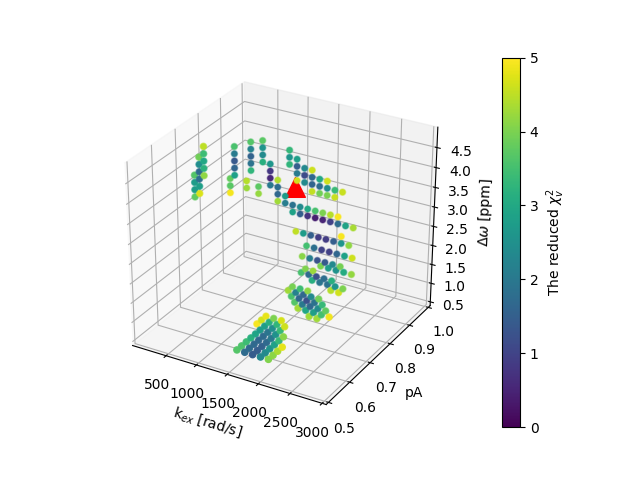

isotope: 15N, dw_min: 0.49, dw_max: 4.91 


In [24]:
# Call plot
# Create figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ref values for dw_rad_1H_1 = 1500 # rad/s at 800 MHz.
#dw_1H = 0.03 # ppm
#dw_15N = 2.39 #
df_1_800 = plot_sim(ax=ax, chi2_max=5.0,
                num=25, Nfields=1,
                model='CR72', cpmg_e=1000., isotope='15N',
                relax_time=0.06,
                w0_1H_s1=800.0,
                R20_s1=15., 
                dw_s1=2.94,
                pA_s1=0.95,
                kex_s1=1000.)

For 1 field, 600 MHz

<IPython.core.display.Javascript object>


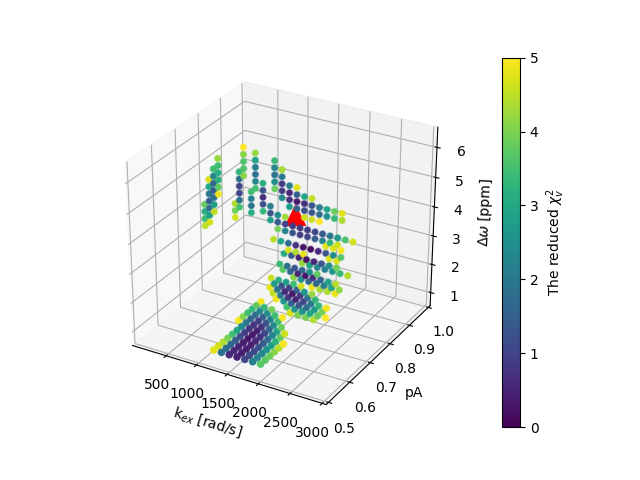

isotope: 15N, dw_min: 0.65, dw_max: 6.54 


In [25]:
# Call plot
# Create figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ref values for dw_rad_1H_1 = 1500 # rad/s at 800 MHz.
#dw_1H = 0.03 # ppm
#dw_15N = 2.39 #
df_1_500 = plot_sim(ax=ax, chi2_max=5.0,
                num=25, Nfields=1,
                model='CR72', cpmg_e=1000., isotope='15N',
                relax_time=0.06,
                w0_1H_s1=600.0,
                R20_s1=15., 
                dw_s1=2.94,
                pA_s1=0.95,
                kex_s1=1000.)

For 2 fields, 800 MHz, 600 MHz

<IPython.core.display.Javascript object>


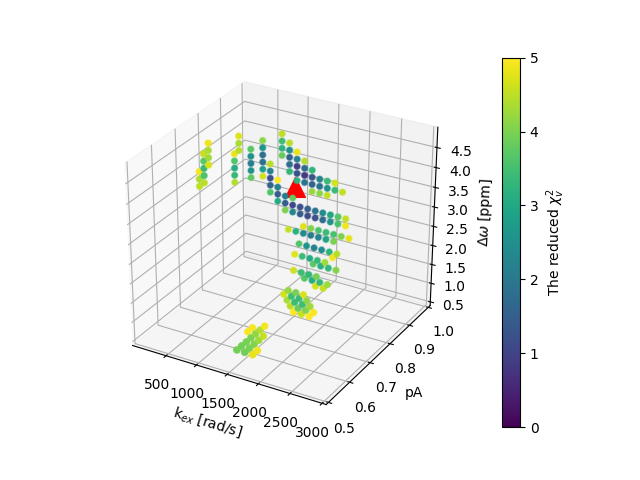

isotope: 15N, dw_min: 0.49, dw_max: 4.91 


In [26]:
# Call plot
# Create figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ref values for dw_rad_1H_1 = 1500 # rad/s at 800 MHz.
#dw_1H = 0.03 # ppm
#dw_15N = 2.39 #
df_2_800_600 = plot_sim(ax=ax, chi2_max=5.0,
                num=25, Nfields=2,
                model='CR72', cpmg_e=1000., isotope='15N',
                relax_time=0.06,
                w0_1H_s1=800.0, w0_1H_s2=600.0, 
                R20_s1=15., 
                dw_s1=2.94,
                pA_s1=0.95,
                kex_s1=1000.)

In [27]:
df_1_800.info()
df_2_800_600.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 4 columns):
kex         191 non-null float64
pA          191 non-null float64
dw          191 non-null float64
avg_chi2    191 non-null float64
dtypes: float64(4)
memory usage: 6.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 4 columns):
kex         166 non-null float64
pA          166 non-null float64
dw          166 non-null float64
avg_chi2    166 non-null float64
dtypes: float64(4)
memory usage: 5.3 KB


For 2 fields, 950 MHz, 500 MHz

<IPython.core.display.Javascript object>


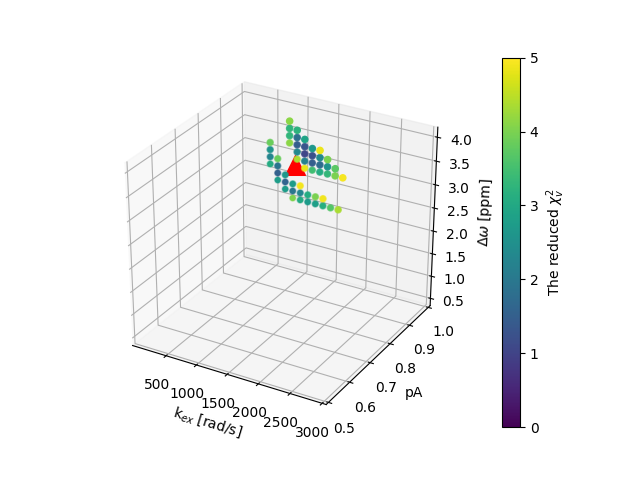

isotope: 15N, dw_min: 0.41, dw_max: 4.13 


In [28]:
# Create figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ref values for dw_rad_1H_1 = 1500 # rad/s at 800 MHz.
#dw_1H = 0.03 # ppm
#dw_15N = 2.39 #
df_2_950_500 = plot_sim(ax=ax, chi2_max=5.0,
                num=25, Nfields=2,
                model='CR72', cpmg_e=1000., isotope='15N',
                relax_time=0.06,
                w0_1H_s1=950.0, w0_1H_s2=500.0, 
                R20_s1=15., 
                dw_s1=2.94,
                pA_s1=0.95,
                kex_s1=1000.)

For 2 fields 800 MHz and 600 MHz, Breakdown. dw < 3 ppm. pA > 0.97

<IPython.core.display.Javascript object>


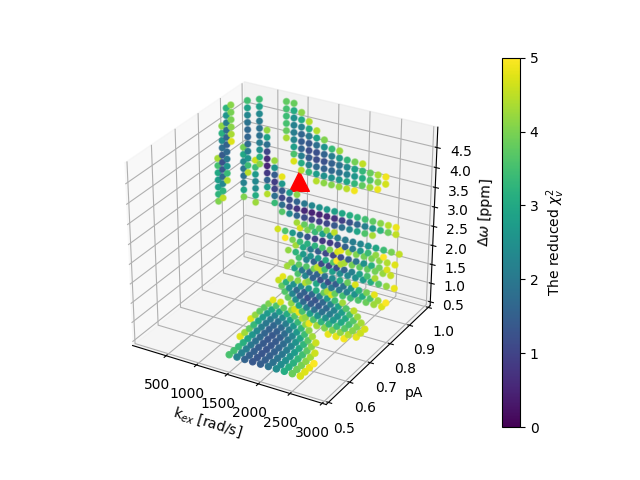

isotope: 15N, dw_min: 0.49, dw_max: 4.91 


In [29]:
# Call plot
# Create figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ref values for dw_rad_1H_1 = 1500 # rad/s at 800 MHz.
#dw_1H = 0.03 # ppm
#dw_15N = 2.39 #
dfx = plot_sim(ax=ax, chi2_max=5.0,
                num=25, Nfields=2,
                model='CR72', cpmg_e=1000., isotope='15N',
                relax_time=0.06,
                w0_1H_s1=800.0, w0_1H_s2=600.0, 
                R20_s1=10., 
                dw_s1=3.0,
                pA_s1=0.97,
                kex_s1=1000.)

In [30]:
# Find suitable plotting
sel_filter = (dfx['avg_chi2'] < 1.0) & (dfx['dw'] < 3 ) & (dfx['pA'] < 0.95 ) & (dfx['pA'] > 0.7 )
dfx[sel_filter]

kex      pA        dw  avg_chi2
205  1375.541667  0.9375  1.779875  0.950161
243  1500.500000  0.9375  1.779875  0.809033
282  1625.458333  0.9375  1.779875  0.873109

<IPython.core.display.Javascript object>


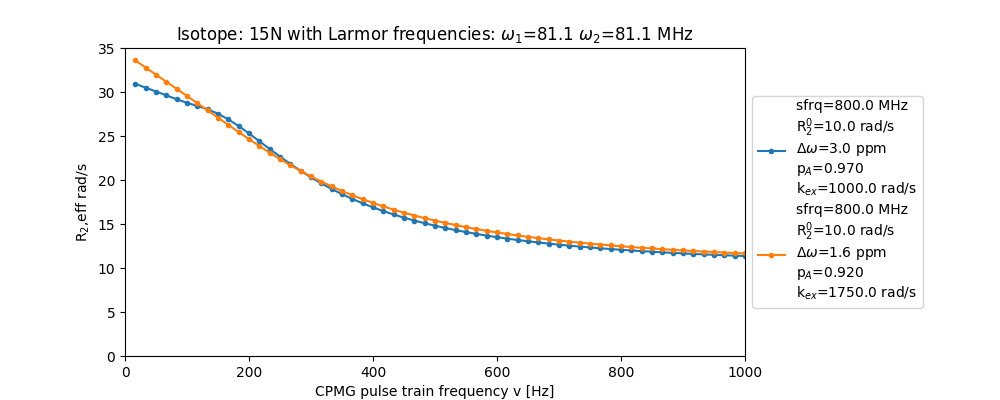

interactive(children=(FloatSlider(value=0.06, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=800.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=800.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=10.0, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=10.0, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=3.0, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=1.6, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.97, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.92, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=1000.0, description='kex_s1', max=10000.0, min=400.0, step=200.0), FloatSlider(value=1750.0, description='kex_s2', max=10000.0, min=400.0, step=200.0), Output()), _dom_classes=('widget-interact',))

In [31]:
def plot_pA_break(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=0.06, 
                w0_1H_s1=800.0, w0_1H_s2=800.0, 
                R20_s1=10., R20_s2=10., 
                dw_s1=3.0, dw_s2=1.6,
                pA_s1=0.97, pA_s2=0.92, 
                kex_s1=1000., kex_s2=1750.):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2)

# Make figure
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_cr72_2 = interactive(plot_pA_break, ax=fixed(ax),
                       model=fixed('CR72'), cpmg_e=fixed(1000), isotope=fixed('15N'), 
                       relax_time=(0.01, 0.1, 0.01), 
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.),
                       R20_min=(0.0, 100., 5.))
# Update fig
widget_cr72_2

## Model differences <a name="modeldiff"></a>

In [32]:
def diff_calc(chi2_min=None, chi2_max=None, num=None,
                model=None, cpmg_e=None, isotope=None,
                relax_time = None, 
                w0_1H_s1=800.0, 
                R20_s1=15.):
    """
    @keyword chi2_min:   The minimum for which to show values.
    @keyword chi2_max:   The maximum for which to show values.
    @keyword num:        The number of grid points for each parameter.
    @keyword model:      The models to analyse.
    @keyword cpmg_e:     The end value of the CPMG pulse train. In Hz.
    @keyword isotope:    The isotope of nuclei. Either 1H, 15N or 13C.
    @keyword relax_time: The experiment specific fixed time period for relaxation (in seconds).
    @keyword w0_1H:      The spin Larmor frequencies for proton. In MHz.
    @keyword R20:        The transversal relaxation rate. In rad/s.
    """
    # Gyromagnetic Ratio in [MHz/T]
    # http://bio.groups.et.byu.net/LarmourFreqCal.phtml
    g = {'1H':42.576, '15N':4.3156, '13C':10.705}
    # Magnet Field Strength [T]
    B0_s1 = w0_1H_s1 / g['1H']
    # Larmor frequency for isotope [MHz]
    w0_isotope_s1 = g[isotope]*B0_s1
    
    # Set dw range
    dw_rad_max = 2500 # rad/2
    # Calculate in ppm
    dw_max = round(dw_rad_max / (w0_isotope_s1*2*np.pi), 2) # ppm
    dw_min = dw_max / 10.
    print("isotope: %s, dw_min: %.2f, dw_max: %.2f " %(isotope, dw_min, dw_max))

    # Then make range of values to test
    kex_range = np.linspace(5., 4000, num=num)
    pA_range = np.linspace(0.55, 1.0, num=num)
    dw_range = np.linspace(dw_min, dw_max, num=num)

    # Loop over data
    xs = [] # kex
    ys = [] # pA
    zs = [] # dw
    cs = [] # Value of reduced chi2 as color
    # Find min, max
    for i, kex_c in enumerate(kex_range):
        for j, pA_c in enumerate(pA_range):
            for k, dw_c in enumerate(dw_range):
                # Get values
                _, y_R2_s1_c, y_R2_s2_c, _, _ = model_calc(
                                        model=model, cpmg_e=cpmg_e, isotope=isotope, 
                                        relax_time=relax_time, 
                                        w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s1, 
                                        R20_s1=R20_s1, R20_s2=R20_s1, 
                                        dw_s1=dw_c, dw_s2=dw_c,
                                        pA_s1=pA_c, pA_s2=pA_c, 
                                        kex_s1=kex_c, kex_s2=kex_c)
                # Then calculate chi2 
                # Chi2
                chi2 = np.sum((y_R2_s1_c - y_R2_s2_c)**2)
                # dof. degrees of freedom equals. The number of values minus the number of parameters
                n_par = 3
                n_obs = len(y_R2_s1_c)
                dof = n_obs - n_par
                # Reduced chi2
                red_chi2 = chi2/dof
                # Avg chi2
                avg_chi2 = chi2/n_obs
                # Assign values
                xs.append(kex_c)
                ys.append(pA_c)        
                zs.append(dw_c)
                #cs.append(chi2)
                cs.append(red_chi2)
                #cs.append(avg_chi2)

    #  Convert to numpy array
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    zs = np.asarray(zs)
    cs = np.asarray(cs)

     # Make filter for removing data points
    # If less than chi2 OR higher than chi2_max
    if chi2_max:
        Nan_f = (cs < chi2_min) | (cs > chi2_max)
    else:
        Nan_f = (cs < chi2_min)
    # Copy and replace
    xs_sel = np.copy(xs)
    ys_sel = np.copy(ys)
    zs_sel = np.copy(zs)
    cs_sel = np.copy(cs)
    # Replace with nan according to mask. This removes data points in graph.
    xs_sel[Nan_f] = np.nan
    ys_sel[Nan_f] = np.nan
    zs_sel[Nan_f] = np.nan
    cs_sel[Nan_f] = np.nan
    
    return xs, xs_sel, ys, ys_sel, zs, zs_sel, cs, cs_sel

def plot_diff(ax=None, chi2_min=0.0, chi2_max=None,
                num=None,
                model=None, cpmg_e=None, isotope='15N',
                relax_time = None, 
                w0_1H_s1=800.0,
                R20_s1=15.):
    """
    @keyword ax:               The matplotlib axis to plot on.
    @keyword chi2_max:         The maximum for which to show values.
    """

    # Get values
    xs, xs_sel, ys, ys_sel, zs, zs_sel, cs, cs_sel = diff_calc(
                chi2_min=chi2_min, chi2_max=chi2_max, num=num,
                model=model, cpmg_e=cpmg_e, isotope=isotope,
                relax_time=relax_time,
                w0_1H_s1=w0_1H_s1,
                R20_s1=R20_s1)

    # Plot points and color bar
    if chi2_max:
        p = ax.scatter(xs_sel, ys_sel, zs_sel, c=cs_sel, vmin=chi2_min, vmax=chi2_max)
    else:
        p = ax.scatter(xs_sel, ys_sel, zs_sel, c=cs_sel, vmin=chi2_min)
    #plt.colorbar(p, label="The average $\chi^2_{avg}$")
    plt.colorbar(p, label="The reduced $\chi^2_{v}$")

    # Set labels and range
    # x
    ax.set_xlabel('k$_{ex}$ [rad/s]')
    ax.set_xlim(np.min(xs), np.max(xs))
    # y
    ax.set_ylabel('pA')
    ax.set_ylim(np.min(ys), np.max(ys))
    # z
    ax.set_zlabel('$\Delta \omega$ [ppm]')
    ax.set_zlim(np.min(zs), np.max(zs))
    
    # Collect the points to return
    df = pd.DataFrame({'kex': xs_sel, 'pA': ys_sel, 'dw': zs_sel, 'avg_chi2': cs_sel})
    # Reorder
    df = df[["kex", "pA", "dw", "avg_chi2"]]
    df = df.dropna(axis=0).reset_index(drop=True)
    return df

Check NS and B14 is equal

<IPython.core.display.Javascript object>


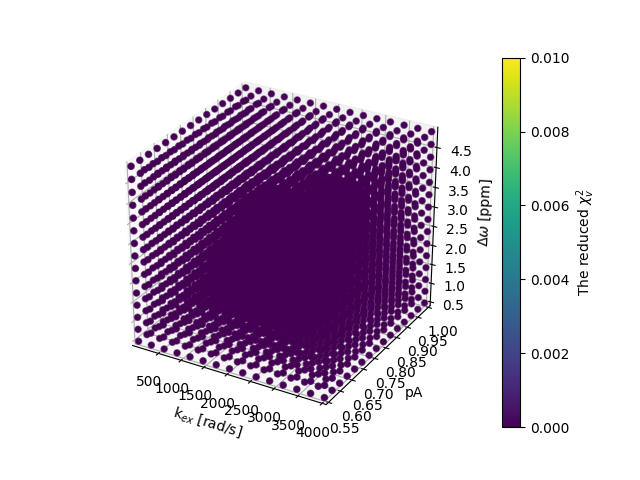

isotope: 15N, dw_min: 0.49, dw_max: 4.91 


In [33]:
# Call plot
# Create figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ref values for dw_rad_1H_1 = 1500 # rad/s at 800 MHz.
#dw_1H = 0.03 # ppm
#dw_15N = 2.39 #
dfx = plot_diff(ax=ax, chi2_min=0.0, chi2_max=0.01,
                num=15, model='NS_B14', cpmg_e=1000., isotope='15N',
                relax_time=0.06,
                w0_1H_s1=800.0, 
                R20_s1=15.)

Difference of CR72 and NS

<IPython.core.display.Javascript object>


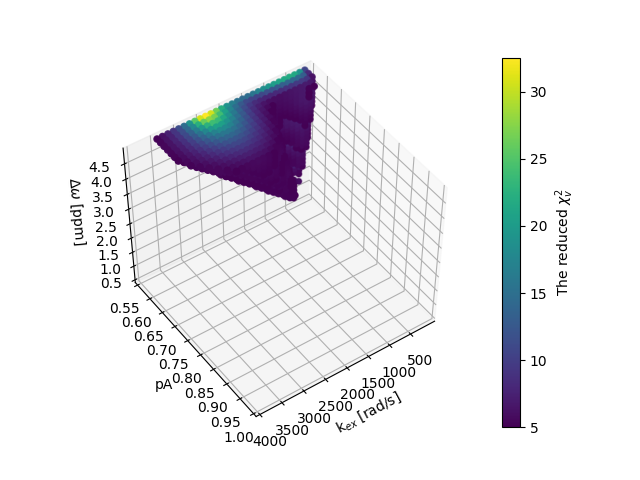

isotope: 15N, dw_min: 0.49, dw_max: 4.91 


In [34]:
# Call plot
# Create figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ref values for dw_rad_1H_1 = 1500 # rad/s at 800 MHz.
#dw_1H = 0.03 # ppm
#dw_15N = 2.39 #
dfx = plot_diff(ax=ax, chi2_min=5.0,
                num=35, model='CR72_NS', cpmg_e=1000., isotope='15N',
                relax_time=0.06,
                w0_1H_s1=800.0, 
                R20_s1=10.)

# Change view
ax.view_init(elev=50., azim=55)

In [35]:
# Find suitable plotting
sel_filter = (dfx['avg_chi2'] > 30.0)
#sel_filter = (dfx['avg_chi2'] > 18) & (dfx['pA'] > 0.6 )
#sel_filter =  (dfx['avg_chi2'] > 1.0) & (dfx['pA'] > 0.7 ) & (dfx['dw'] < 4. )
dfx[sel_filter]

kex    pA        dw   avg_chi2
2481  2237.5  0.55  4.650059  30.771972
2482  2237.5  0.55  4.780029  31.109829
2483  2237.5  0.55  4.910000  30.567971
2622  2355.0  0.55  4.780029  31.212416
2623  2355.0  0.55  4.910000  32.547993
2747  2472.5  0.55  4.910000  30.706359

<IPython.core.display.Javascript object>


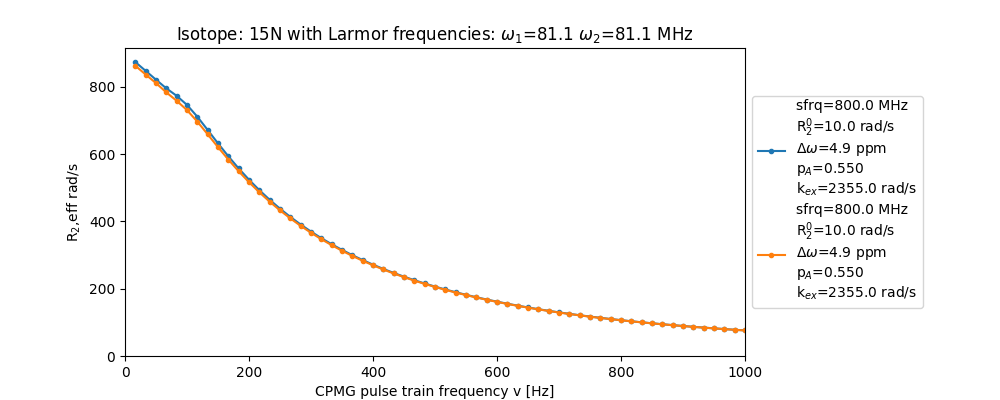

interactive(children=(FloatSlider(value=0.06, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=800.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=800.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=10.0, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=10.0, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=4.91, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=4.91, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.55, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.55, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=2355.0, description='kex_s1', max=10000.0, min=400.0, step=200.0), FloatSlider(value=2355.0, description='kex_s2', max=10000.0, min=400.0, step=200.0), Output()), _dom_classes=('widget-interact',))

In [36]:
def plot_CR72_diff(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=0.06, 
                w0_1H_s1=800.0, w0_1H_s2=800.0, 
                R20_s1=10., R20_s2=10., 
                dw_s1=4.91, dw_s2=4.91,
                pA_s1=0.55, pA_s2=0.55, 
                kex_s1=2355.0, kex_s2=2355.0):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2)

# Make figure
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_cr72_3 = interactive(plot_CR72_diff, ax=fixed(ax),
                       model=fixed('CR72_NS'), cpmg_e=fixed(1000), isotope=fixed('15N'), 
                       relax_time=(0.01, 0.1, 0.01), 
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.),
                       R20_min=(0.0, 100., 5.))
# Update fig
widget_cr72_3

Difference of CR72 and NS for short relax times

<IPython.core.display.Javascript object>


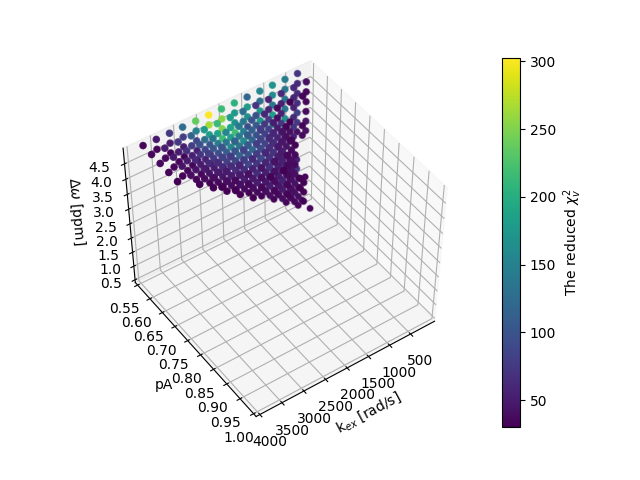

isotope: 15N, dw_min: 0.49, dw_max: 4.91 


In [37]:
# Call plot
# Create figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Ref values for dw_rad_1H_1 = 1500 # rad/s at 800 MHz.
#dw_1H = 0.03 # ppm
#dw_15N = 2.39 #
dfx = plot_diff(ax=ax, chi2_min=30.0,
                num=15, model='CR72_NS', cpmg_e=1000., isotope='15N',
                relax_time=0.02,
                w0_1H_s1=800., 
                R20_s1=10.)

# Change view
ax.view_init(elev=50., azim=55)

In [38]:
# Find suitable plotting
#sel_filter = (dfx['avg_chi2'] > 50.0)
#sel_filter = (dfx['avg_chi2'] > 50) & (dfx['pA'] > 0.6 )
sel_filter =  (dfx['avg_chi2'] > 50) & (dfx['pA'] > 0.6 ) & (dfx['dw'] < 3. )
dfx[sel_filter]

kex        pA        dw   avg_chi2
63    861.071429  0.614286  2.069214  54.388800
96   1146.428571  0.614286  2.384857  68.230961
97   1146.428571  0.614286  2.700500  70.093751
107  1146.428571  0.646429  2.700500  54.972996
143  1431.785714  0.614286  2.700500  66.248126
152  1431.785714  0.646429  2.700500  50.661030

<IPython.core.display.Javascript object>


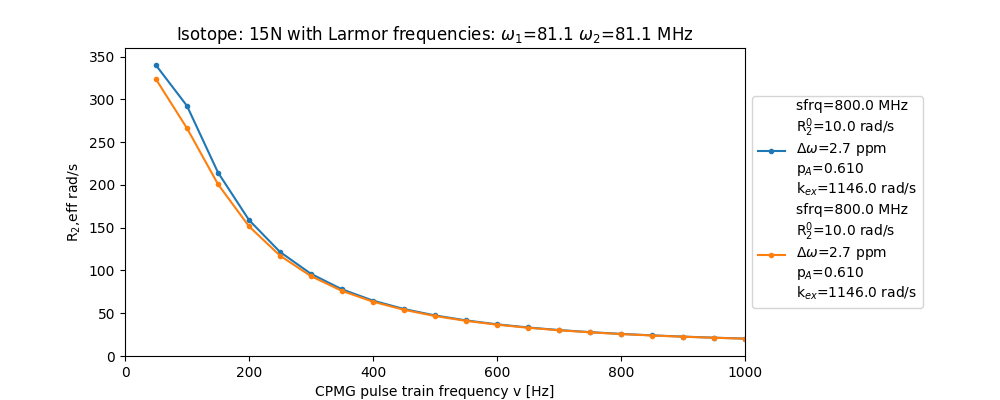

interactive(children=(FloatSlider(value=0.02, description='relax_time', max=0.1, min=0.01, step=0.01), FloatSlider(value=800.0, description='w0_1H_s1', max=1000.0, min=500.0, step=50.0), FloatSlider(value=800.0, description='w0_1H_s2', max=1000.0, min=500.0, step=50.0), FloatSlider(value=10.0, description='R20_s1', max=25.0, min=5.0, step=1.0), FloatSlider(value=10.0, description='R20_s2', max=25.0, min=5.0, step=1.0), FloatSlider(value=2.7, description='dw_s1', max=10.0, min=0.1), FloatSlider(value=2.7, description='dw_s2', max=10.0, min=0.1), FloatSlider(value=0.61, description='pA_s1', max=1.0, min=0.5, step=0.01), FloatSlider(value=0.61, description='pA_s2', max=1.0, min=0.5, step=0.01), FloatSlider(value=1146.0, description='kex_s1', max=10000.0, min=400.0, step=200.0), FloatSlider(value=1146.0, description='kex_s2', max=10000.0, min=400.0, step=200.0), Output()), _dom_classes=('widget-interact',))

In [39]:
def plot_CR72_diff_2(ax=None, model=None, cpmg_e=None, isotope=None, 
                relax_time=0.02, 
                w0_1H_s1=800.0, w0_1H_s2=800.0, 
                R20_s1=10., R20_s2=10., 
                dw_s1=2.70, dw_s2=2.70,
                pA_s1=0.61, pA_s2=0.61, 
                kex_s1=1146.0, kex_s2=1146.0):
    # Call normal function
    plot_calc(ax=ax, model=model, cpmg_e=cpmg_e, isotope=isotope,
             relax_time=relax_time,
             w0_1H_s1=w0_1H_s1, w0_1H_s2=w0_1H_s2,
             R20_s1=R20_s1, R20_s2=R20_s2, 
             dw_s1=dw_s1, dw_s2=dw_s2, 
             pA_s1=pA_s1, pA_s2=pA_s2, 
             kex_s1=kex_s1, kex_s2=kex_s2)

# Make figure
fig, ax = plt.subplots(1, figsize=(10, 4))
widget_cr72_4 = interactive(plot_CR72_diff_2, ax=fixed(ax),
                       model=fixed('CR72_NS'), cpmg_e=fixed(1000), isotope=fixed('15N'), 
                       relax_time=(0.01, 0.1, 0.01), 
                       w0_1H_s1=(500., 1000., 50), w0_1H_s2=(500., 1000., 50),
                       R20_s1=(5.0, 25.0, 1.), R20_s2=(5.0, 25.0, 1.),
                       dw_s1=(0.1, 10., 0.1), dw_s2=(0.1, 10., 0.1),
                       pA_s1=(0.500, 1.000, 0.01), pA_s2=(0.500, 1.000, 0.01),
                       kex_s1=(400., 10000, 200.), kex_s2=(400., 10000, 200.),
                       R20_min=(0.0, 100., 5.))
# Update fig
widget_cr72_4


# References <a name="references"></a>

## Ipywidgets documentation

* [Using Interact](http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)
* [Widget List](http://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html)
* [How to 'Save Notebook Widget State' before exporting to online view.](http://ipywidgets.readthedocs.io/en/stable/embedding.html)
* [Matplotlib documentation on backend.]( https://matplotlib.org/faq/usage_faq.html#what-is-a-backend)
* [stackoverflow on updates a plot in a loop](https://stackoverflow.com/questions/34486642/what-is-the-currently-correct-way-to-dynamically-update-plots-in-jupyter-ipython)
* [Widget at plotting in matplotlib. Does not work as intended.](http://nbviewer.jupyter.org/github/jenshnielsen/netcdf-lesson/blob/master/Interactive%20plotting%20with%20nbagg.ipynb)


## Code reference in relax

* [The target function to prepare data](https://github.com/nmr-relax/relax/blob/master/target_functions/relax_disp.py)
* [The library function of CR72](https://github.com/nmr-relax/relax/blob/master/lib/dispersion/cr72.py)
* [The library function of 'NS CPMG 2-site expanded'](https://github.com/nmr-relax/relax/blob/master/lib/dispersion/ns_cpmg_2site_expanded.py)
* [The library function of B14](https://github.com/nmr-relax/relax/blob/master/lib/dispersion/b14.py)